# 특강 프로젝트

- 예시로 cartpole, mountaincar, acrobot 도전으로 bipedalwalker or car-racing
dqn, pg, actor-critic 까지 돌리고 분석(plot, board)

- ppt 순서는 강화학습 소개 - gym 소개 - 실습 별 환경 및 이론 소개 - 실습

- correlation, non stationary target 때문에 simple 한 q - learning 은 잘 안됨

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import gym
import tensorflow as tf
import random
import numpy as np
from collections import deque
import dqn

In [4]:
import sys
sys.path.append('C:\\Users\\itfor\\Anaconda3\\Lib\\site-packages')

- simple Q learning

In [5]:
env = gym.make('CartPole-v1')

In [6]:
size_s = env.observation_space.shape[0]
size_w1 = 8
size_w2 = 20
size_w3 = 10
size_out = env.action_space.n
lr = .1 ##Learning rate
total_episode = 1000
epsilon = .1
gamma = .95 ##discount factor

STATE_IN = tf.placeholder(tf.float32, shape=[None, size_s])
targetQ = tf.placeholder(tf.float32, shape=[None, size_out])
W_1 = tf.Variable(tf.random_normal([size_s, size_w1]))
W_2 = tf.Variable(tf.random_normal([size_w1, size_w2]))
W_3 = tf.Variable(tf.random_normal([size_w2, size_w3]))
OUT = tf.Variable(tf.random_normal([size_w3, size_out]))

In [7]:
L_1 = (tf.matmul(STATE_IN, W_1))
L_2 = (tf.matmul(L_1, W_2))
L_3 = tf.matmul(L_2, W_3)
Qout = (tf.matmul(L_3, OUT))
loss = tf.reduce_mean(tf.square(Qout - targetQ))
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

In [8]:
def make_graph(x, y):
    plt.ion()
    fig = plt.figure()
    sp = fig.add_subplot(111)
    plt.xlim([0, 2000])
    plt.ylim([0, 2000])
    line, = plt.plot(x, y, 'b')
    sp.set_xlabel('episode')
    sp.set_ylabel('reward')
    return fig, sp, line

<IPython.core.display.Javascript object>


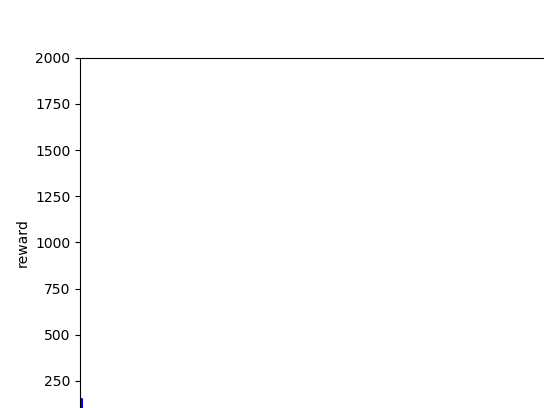

22
10
10
17
37
48
153
40
20
11
64
91
48
17
30
51
90


KeyboardInterrupt: 

In [9]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    state = env.reset()
    ep = 1
    step = 0
    total_reward = 0
    
     # 그래프 생성
    x_data = []
    y_data = []
    fig, sp, line = make_graph(x_data, y_data)
    
    while ep < total_episode:
        step += 1
        env.render() 
        state = np.reshape(state, newshape=[1, size_s])
        Q_prev = sess.run(Qout, feed_dict={STATE_IN:state})
        
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_prev)
            
        new_state, r, d, _ = env.step(action)

        if d:
            # 그래프 그리기
            x_data.append(ep)
            y_data.append(step)

            line.set_xdata(x_data)
            line.set_ydata(y_data)
            fig.canvas.draw()
            
            
            target[0,action] = -100
            epsilon = 1./((ep/50) + 10)
            print(step)
            step = 0
            ep += 1
            state = env.reset()
        else:
            new_state = np.reshape(new_state, newshape=[1, size_s])
            Q_cur = sess.run(Qout, feed_dict={STATE_IN:new_state})
            target = Q_prev
            target[0,action] = r + gamma*np.argmax(Q_cur)

            sess.run(optimizer, feed_dict={targetQ:target, STATE_IN:state})
            state = new_state
            
env.close()

- DQN

In [9]:
def copy(*, dest_scope_name = 'target', src_scope_name = 'main') :
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope = dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars) :
        op_holder.append(dest_var.assign(src_var))
        
    return op_holder


In [ ]:
def replay_train(mainDQN, targetDQN, train_batch) :
    x_stack = np.empty(0).reshape(0, size_s)
    y_stack = np.empty(0).reshape(0, size_out)
    
    for state, action, reward, next_state, done in train_batch :
        Q = mainDQN.predict(state)
        
        if done :
            Q[0, action] = -100
        
        else :
            Q[0, action] = reward + gamma*np.max(targetDQN.predict(next_state))
        
        x_stack = np.vstack([x_stack, state])
        y_stack = np.vstack([y_stack, Q])
        
    return mainDQN.update(x_stack, y_stack)

In [2]:
total_episode = 1000
replay_buffer = deque()
ep = 0
step = 0

with tf.Session() as sess:
    
      
     # 그래프 생성
    x_data = []
    y_data = []
    fig, sp, line = make_graph(x_data, y_data)
    
    mainDQN = dqn.DQN(sess, size_s, size_out, name='main')
    targetDQN = dqn.DQN(sess, size_s, size_out, name='target')
    
    tf.global_variables_initializer().run()
    copy_ops = copy(dest_scope_name='targetDQN', src_scope_name='mainDQN')
    sess.run(copy_ops)
    
    state = env.reset()
    
    for episode in range(total_episode) :
        e = 1. / ((episode / 10) + 1)
        done = False
        step_count = 0
        state = env.reset()
        
        
        while not done :
             
            if np.random.rand(1) < e :
                action = env.action_space.sample()
            else :
                action = np.argmax(mainDQN.predict(state))
                    
            next_state, reward, done, _ = env.step(action)
                
            if done : 
                reward = -100
                
                
                
            replay_buffer.append((state, action, reward, next_state, done))
            if(len(replay_buffer) > 50000) :
                replay_buffer.popleft()
             
            state = next_state
            step_count += 1
                
            if(step_count > 10000) :
                break
        
         # 그래프 그리기
        x_data.append(episode)
        y_data.append(step_count)

        line.set_xdata(x_data)
        line.set_ydata(y_data)
        fig.canvas.draw()
        
        print ('episode : {}, steps : {}'.format(episode, step_count))
                
        if(step_count > 10000) :
            pass
                
        if(episode % 10 == 1) :
            for _ in range(50) :
                minibacth = random.sample(replay_buffer, 10)
                loss, _ = replay_train(mainDQN, targetDQN, minibacth)
                        
            print('loss :', loss)
            sess.run(copy_ops)
                    
    env.close()

NameError: name 'deque' is not defined